# **Import Necessary Libraries**

In [1]:
!pip install mlflow

In [2]:
!pip install keras_tuner

In [3]:
!pip install mlflow pyngrok --quiet

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, classification_report , auc
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_curve
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

from tensorflow.keras import models, layers
from imblearn.over_sampling import SMOTE

import joblib
import mlflow
import mlflow.sklearn
from tensorflow.keras.models import load_model
import tempfile

from sklearn.model_selection import RandomizedSearchCV

# For Saving the Model
from joblib import dump , load

from keras_tuner.tuners import RandomSearch
import gradio

# **Load the dataset**

In [5]:
customer = pd.read_csv("/content/customer_churn.csv")

In [6]:
customer.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# **Data Inspection**

In [7]:
#shows all the columns available
pd.set_option("display.max_columns", None)
pd.set_option("display.expand_frame_repr",False)
pd.set_option("max_colwidth",None)

In [8]:
## Preview of Data
customer.head(4)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No


In [9]:
# Basic Info about the dataset
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [10]:
# Summary Statistics for the numercial columns
customer.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [11]:
# Summary Statistics for the categorical columns
customer.describe(include=['object', 'category'])

,customerID,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,TotalCharges,Churn
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,7043,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4,6531,2
top,3186-AJIEK,Male,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,,No
freq,1,3555,3641,4933,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,11,5174


In [12]:
# Shape of the data
customer.shape

(7043, 21)

In [13]:
# To get all the column names
customer.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [14]:
# Checking if any null values are there:
customer.isnull().sum()

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


In [15]:
# Checking if any duplicate values  are there :
print(f'{customer.duplicated().sum()}')

0


# **DATA MANIPULATION**

In [16]:
# Extract the 5th column and store it in ‘customer_5’
customer_5 = customer.iloc[:,4]
customer_5

,Dependents
0,No
1,No
2,No
3,No
4,No
...,...
7038,Yes
7039,Yes
7040,Yes
7041,No


In [17]:
# Extract the 15th column and store it in ‘customer_15’
customer_15 = customer.iloc[:,14]
customer_15

,StreamingMovies
0,No
1,No
2,No
3,No
4,No
...,...
7038,Yes
7039,Yes
7040,No
7041,No


In [18]:
# Extract all the male senior citizens whose payment method is electronic check and store the result in ‘senior_male_electronic’

senior_male_electronic = customer[(customer['gender'] == 'Male') & (customer['PaymentMethod'] == 'Electronic check' )]
senior_male_electronic.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
14,5129-JLPIS,Male,0,No,No,25,Yes,No,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,105.50,2686.05,No
20,8779-QRDMV,Male,1,No,No,1,No,No phone service,DSL,No,No,Yes,No,No,Yes,Month-to-month,Yes,Electronic check,39.65,39.65,Yes
26,6467-CHFZW,Male,0,Yes,Yes,47,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.35,4749.15,Yes


In [19]:
# Extract all those customers whose tenure is greater than 70 months or their monthly charges is more than $100 and store the result in
# ‘customer_total_tenure’

customer_total_tenure = customer[(customer['tenure'] > 70 ) | (customer['MonthlyCharges'] > 100.0 )]
customer_total_tenure.head(2)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
8,7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
12,8091-TTVAX,Male,0,Yes,No,58,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,One year,No,Credit card (automatic),100.35,5681.1,No


In [20]:
# Extract all the customers whose contract is of two years, payment method is mailed check and the value of churn is ‘Yes’ and store the result in
# ‘two_mail_yes’

two_mail_yes = customer[(customer['Contract'] == 'Two year') & (customer['PaymentMethod'] == 'Mailed check') & (customer['Churn'] == 'Yes' )]
two_mail_yes.head(2)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
268,6323-AYBRX,Male,0,No,No,59,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.35,1099.6,Yes
5947,7951-QKZPL,Female,0,Yes,Yes,33,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Mailed check,24.50,740.3,Yes


In [21]:
# Extract 333 random records from the customer_churndataframe and store
# the result in ‘customer_333’

customer_333 = customer.sample(333)

In [22]:
#Get the count of different levels from the ‘Churn’ column
churn_count = customer['Churn'].value_counts()
churn_count

,count
Churn,
No,5174
Yes,1869


# **Visualization**

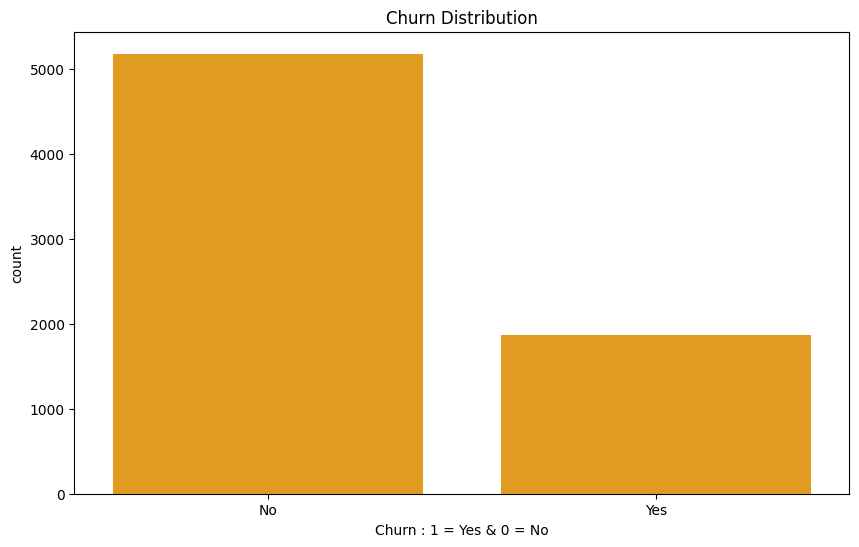

In [23]:
plt.figure(figsize=(10,6))
sns.countplot(data=customer,x='Churn',color='orange')
plt.title("Churn Distribution")
plt.xlabel("Churn : 1 = Yes & 0 = No")
plt.show()

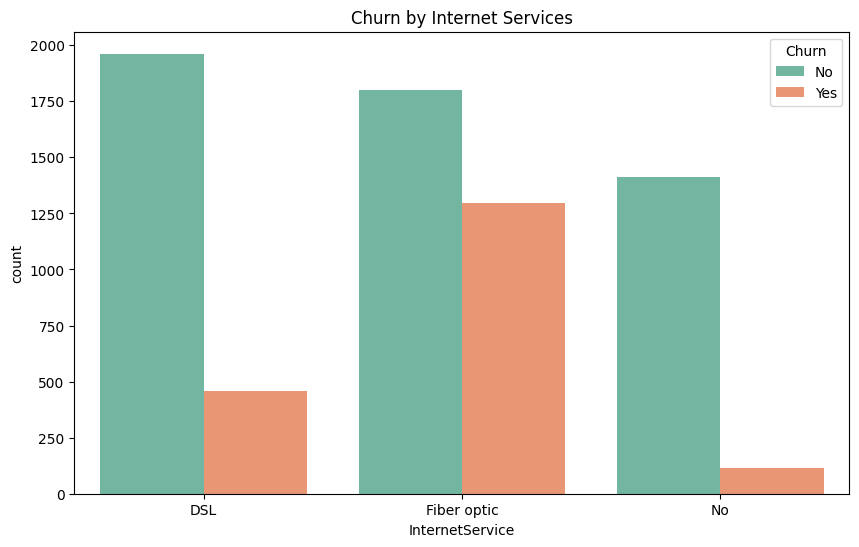

In [24]:
plt.figure(figsize=(10,6))
sns.countplot(data=customer,x='InternetService', hue = 'Churn',palette = 'Set2')
plt.title("Churn by Internet Services")
plt.show()

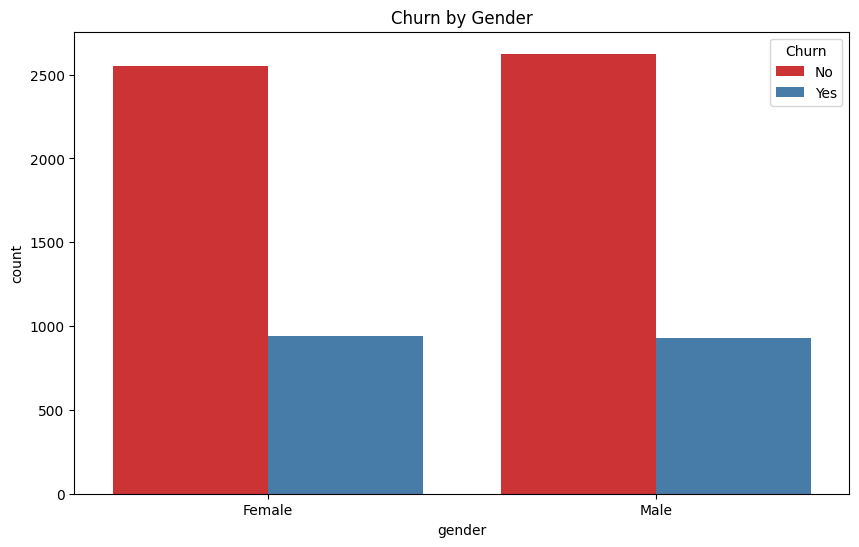

In [25]:
plt.figure(figsize=(10,6))
sns.countplot(data=customer,x='gender', hue = 'Churn',palette = 'Set1')
plt.title("Churn by Gender")
plt.show()

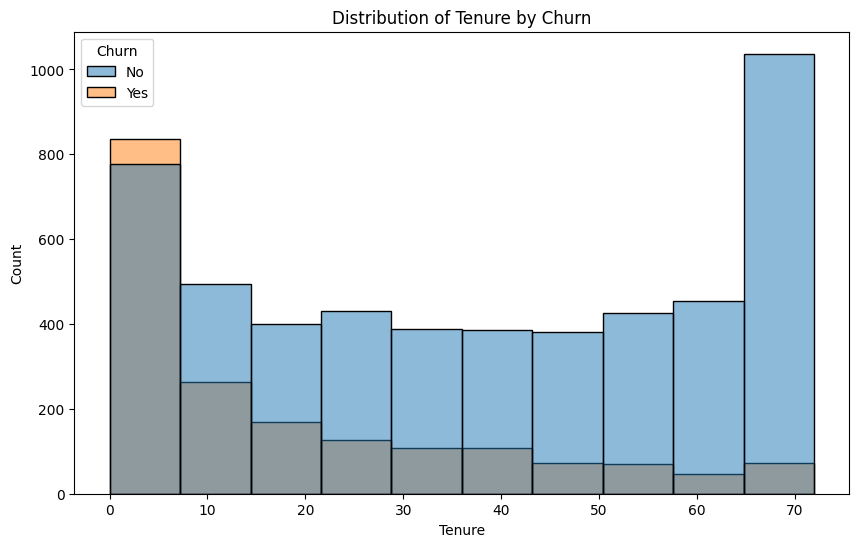

In [26]:
plt.figure(figsize=(10,6))
sns.histplot(data=customer, x= 'tenure', hue = 'Churn',bins=10 )
plt.title("Distribution of Tenure by Churn")
plt.xlabel("Tenure")
plt.show()

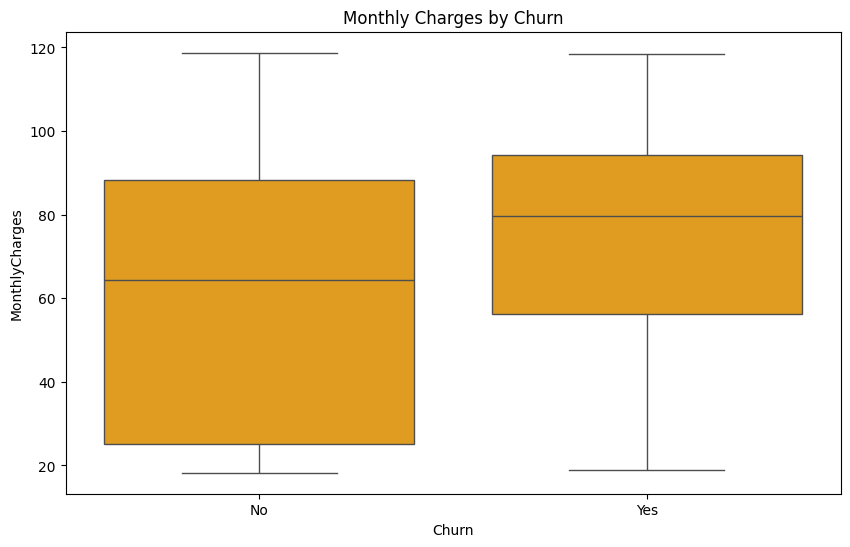

In [27]:
plt.figure(figsize=(10,6))
sns.boxplot(data=customer, x = 'Churn' , y = 'MonthlyCharges', color = 'orange')
plt.title("Monthly Charges by Churn")
plt.show()

In [28]:
# Model wont understand the categorical columns so we need to do encoding :

# To get all the categorical columns along with all unique values present in it.
for col in customer.columns :
    if customer[col].dtypes == 'object' :
        print(f"{col} : {customer[col].unique()}")

customerID : ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender : ['Female' 'Male']
Partner : ['Yes' 'No']
Dependents : ['No' 'Yes']
PhoneService : ['No' 'Yes']
MultipleLines : ['No phone service' 'No' 'Yes']
InternetService : ['DSL' 'Fiber optic' 'No']
OnlineSecurity : ['No' 'Yes' 'No internet service']
OnlineBackup : ['Yes' 'No' 'No internet service']
DeviceProtection : ['No' 'Yes' 'No internet service']
TechSupport : ['No' 'Yes' 'No internet service']
StreamingTV : ['No' 'Yes' 'No internet service']
StreamingMovies : ['No' 'Yes' 'No internet service']
Contract : ['Month-to-month' 'One year' 'Two year']
PaperlessBilling : ['Yes' 'No']
PaymentMethod : ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
TotalCharges : ['29.85' '1889.5' '108.15' ... '346.45' '306.6' '6844.5']
Churn : ['No' 'Yes']


In [29]:
# As total charges is a numerical col we need to remove it from the object
customer['TotalCharges'] = pd.to_numeric(customer['TotalCharges'],errors = 'coerce')

In [30]:
print(customer['TotalCharges'].isnull().sum())

11


In [31]:
customer.dropna(inplace=True)

In [32]:
print(customer['TotalCharges'].isnull().sum())

0


In [33]:
# Intializing the Label Encoding
le = LabelEncoder()

for col in customer.columns :
    if customer[col].dtypes == 'object' :
        customer[col] = le.fit_transform(customer[col])
        print(le.classes_)

['0002-ORFBO' '0003-MKNFE' '0004-TLHLJ' ... '9992-UJOEL' '9993-LHIEB'
 '9995-HOTOH']
['Female' 'Male']
['No' 'Yes']
['No' 'Yes']
['No' 'Yes']
['No' 'No phone service' 'Yes']
['DSL' 'Fiber optic' 'No']
['No' 'No internet service' 'Yes']
['No' 'No internet service' 'Yes']
['No' 'No internet service' 'Yes']
['No' 'No internet service' 'Yes']
['No' 'No internet service' 'Yes']
['No' 'No internet service' 'Yes']
['Month-to-month' 'One year' 'Two year']
['No' 'Yes']
['Bank transfer (automatic)' 'Credit card (automatic)' 'Electronic check'
 'Mailed check']
['No' 'Yes']


In [34]:
customer.head(2)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,5365,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85,0
1,3953,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50,0


# **Feature Engineering using RFE:**

The Selected Features are : ['tenure', 'TechSupport', 'Contract', 'TotalCharges', 'PaymentMethod', 'MonthlyCharges']


Text(0.5, 1.0, 'Feature importance')

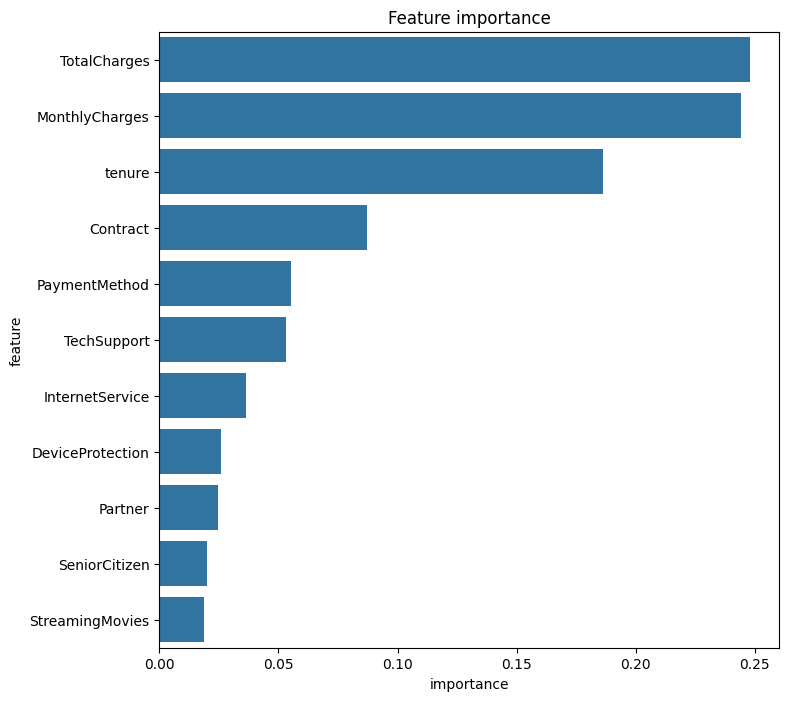

In [35]:
suggested_features = ['SeniorCitizen','tenure','DeviceProtection','TechSupport','Contract','TotalCharges',
                      'PaymentMethod','MonthlyCharges','StreamingMovies','Partner','InternetService'
                     ]

X = customer[suggested_features]
y= customer['Churn']

# To implement random forest classifier as a baseline model for RFE:
rfc = RandomForestClassifier(n_estimators=110 , random_state = 3)

# initializing the RFE:
rfe = RFE(estimator = rfc , n_features_to_select = 6) #top n features to select for further analysis.
# Fit the rfe :
rfe.fit(X,y)

selected_features = [feature for feature, selected in zip(suggested_features , rfe.support_) if selected]
print(f'The Selected Features are : {selected_features}')

# fit the randomforestclassifier
rfc.fit(X,y)


imporatnces = pd.DataFrame({'feature':suggested_features, 'importance': rfc.feature_importances_})
imporatnces = imporatnces.sort_values('importance', ascending=False)
imporatnces

#plot
plt.figure(figsize=(8,8))
sns.barplot(x='importance', y='feature', data=imporatnces)
plt.title("Feature importance")

# **Defining X and Y variables and Train test split**

In [36]:
X = customer[selected_features]
y = customer['Churn']

# Splitting the data into train and test set
X_train , X_test , y_train , y_test = train_test_split( X , y , test_size = 0.2 , random_state = 42)

# Scailing
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# **Appyling Logistics Regression on imbalanced dataset**

Accuracy Score : 0.7810945273631841

 The Classification Report : 

               precision    recall  f1-score   support

           0       0.83      0.88      0.86      1033
           1       0.61      0.50      0.55       374

    accuracy                           0.78      1407
   macro avg       0.72      0.69      0.70      1407
weighted avg       0.77      0.78      0.77      1407



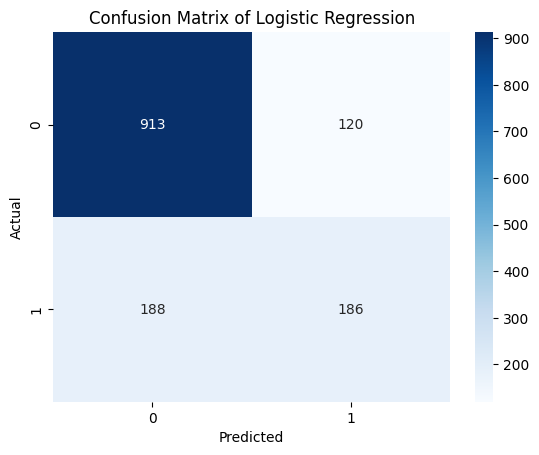

In [37]:
# Intializing the model :
Lrs = LogisticRegression(max_iter=100)

# Train the model using fit
Lrs.fit(X_train_scaled,y_train)

# Testing of the model/prediction
y_pred_lor = Lrs.predict(X_test_scaled)

# To evaluate how model is performing
print(f'Accuracy Score : {accuracy_score(y_test,y_pred_lor)}')
print("\n",f'The Classification Report : ')
print("\n", classification_report(y_test, y_pred_lor))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred_lor), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix of Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# **Training Using XGBoost on Imbalanced dataset**

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:03:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy Score : 0.7569296375266524

 The Classification Report : 

               precision    recall  f1-score   support

           0       0.81      0.87      0.84      1033
           1       0.55      0.44      0.49       374

    accuracy                           0.76      1407
   macro avg       0.68      0.66      0.67      1407
weighted avg       0.74      0.76      0.75      1407



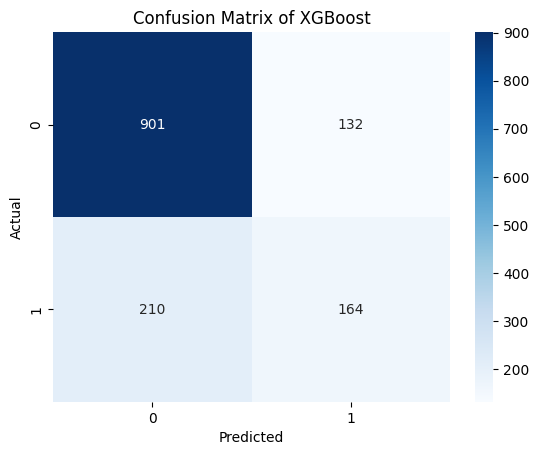

In [38]:
# Initializing the model
xgb_cls = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Train the model using fit
xgb_cls.fit(X_train_scaled, y_train)

# Testing of the model/prediction
y_pred_xgb = xgb_cls.predict(X_test_scaled)

# To evaluate how model is performing
print(f'Accuracy Score : {accuracy_score(y_test,y_pred_xgb)}')
print("\n",f'The Classification Report : ')
print("\n", classification_report(y_test,y_pred_xgb))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix of XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

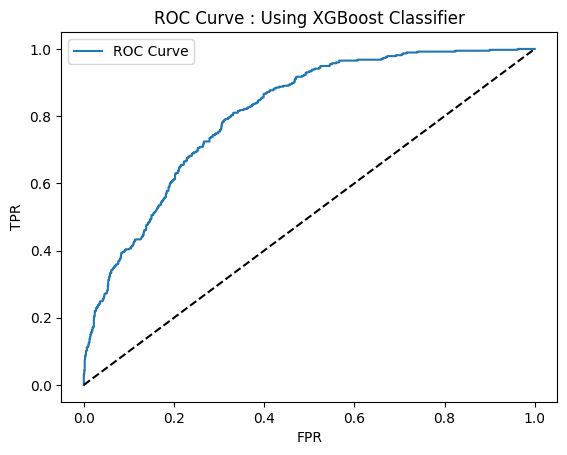

In [39]:
# ROC Curve
y_pred_proba = xgb_cls.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label="ROC Curve")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve : Using XGBoost Classifier")
plt.legend()
plt.show()

# **Appyling Smote and Training Logistics Regression Models**

Accuracy Score : 0.7128642501776831

 The Classification Report : 

               precision    recall  f1-score   support

           0       0.90      0.69      0.78      1033
           1       0.48      0.78      0.59       374

    accuracy                           0.71      1407
   macro avg       0.69      0.74      0.69      1407
weighted avg       0.79      0.71      0.73      1407



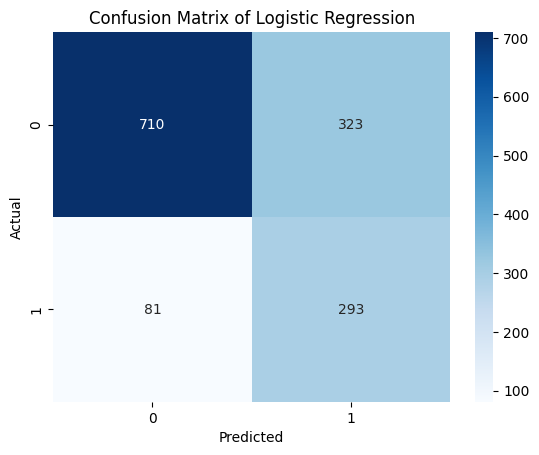

In [40]:
# Applying Smote as data is not balanced :
# Oversampling
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# Building a Logistics Regression model:

# Intializing the model :
Lrs = LogisticRegression(max_iter=100)

# Train the model using fit
Lrs.fit(X_train_smote,y_train_smote)

# Testing of the model/prediction
y_pred = Lrs.predict(X_test_scaled)

# To evaluate how model is performing
print(f'Accuracy Score : {accuracy_score(y_test,y_pred)}')
print("\n",f'The Classification Report : ')
print("\n", classification_report(y_test, y_pred))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix of Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


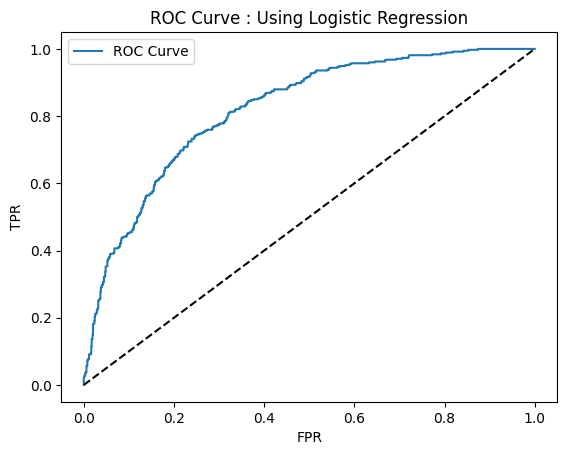

In [41]:
# ROC Curve
y_pred_proba = Lrs.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label="ROC Curve")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve : Using Logistic Regression")
plt.legend()
plt.show()

# **Decision Tree Classifier**

Accuracy Score : 0.6936744847192609

 The Classification Report : 

               precision    recall  f1-score   support

           0       0.82      0.75      0.78      1033
           1       0.44      0.54      0.48       374

    accuracy                           0.69      1407
   macro avg       0.63      0.64      0.63      1407
weighted avg       0.72      0.69      0.70      1407



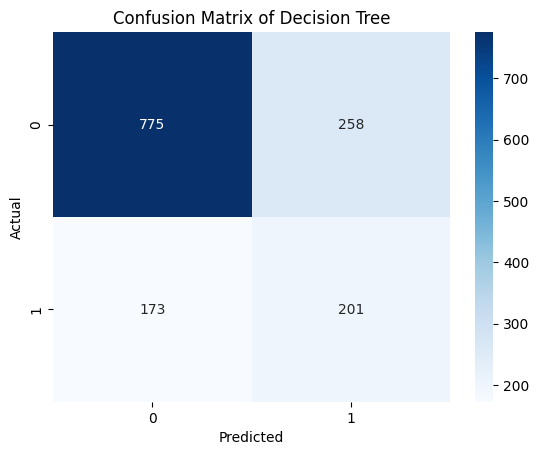

In [42]:
# intializing the model :
dtc = DecisionTreeClassifier()

# Train the model using fit
dtc.fit(X_train_smote,y_train_smote)

# Testing of the model/prediction
y_pred_dtc = dtc.predict(X_test_scaled)

# To evaluate how model is performing
print(f'Accuracy Score : {accuracy_score(y_test,y_pred_dtc)}')
print("\n",f'The Classification Report : ')
print("\n", classification_report(y_test, y_pred_dtc))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred_dtc), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix of Decision Tree")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

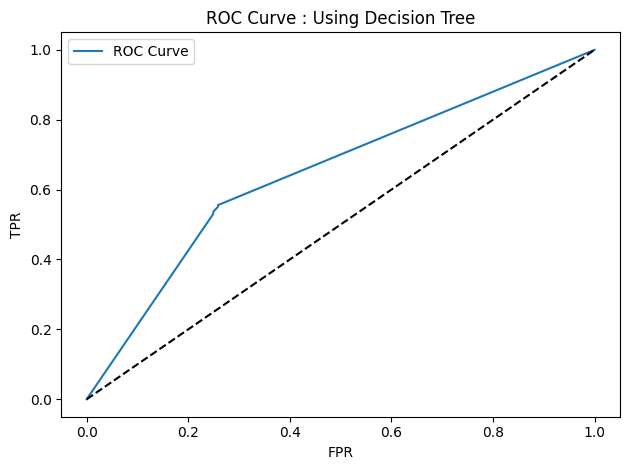

In [43]:
# ROC Curve
y_pred_proba_dtc = dtc.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_dtc)
plt.plot(fpr, tpr, label="ROC Curve")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve : Using Decision Tree")
plt.legend()

plt.tight_layout()
plt.show()

# **Training Using Random Forest**

Accuracy Score : 0.7412935323383084

 The Classification Report : 

               precision    recall  f1-score   support

           0       0.84      0.80      0.82      1033
           1       0.51      0.59      0.55       374

    accuracy                           0.74      1407
   macro avg       0.68      0.69      0.68      1407
weighted avg       0.75      0.74      0.75      1407



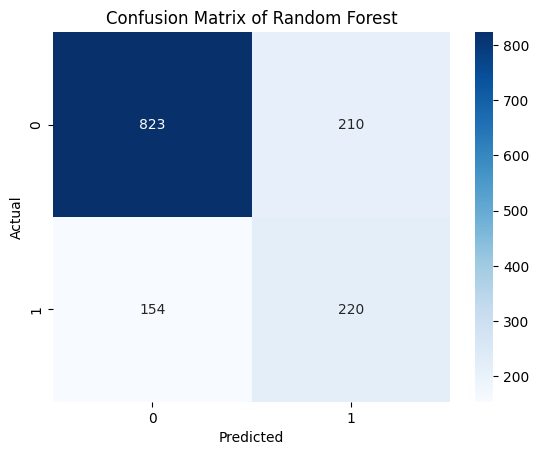

In [44]:
# Intializing the model :
rfc = RandomForestClassifier()

# Train the model using fit
rfc.fit(X_train_smote,y_train_smote)

# Testing of the model/prediction
y_pred_rfc = rfc.predict(X_test_scaled)

# To evaluate how model is performing
print(f'Accuracy Score : {accuracy_score(y_test,y_pred_rfc)}')
print("\n",f'The Classification Report : ')
print("\n", classification_report(y_test, y_pred_rfc))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred_rfc), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix of Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

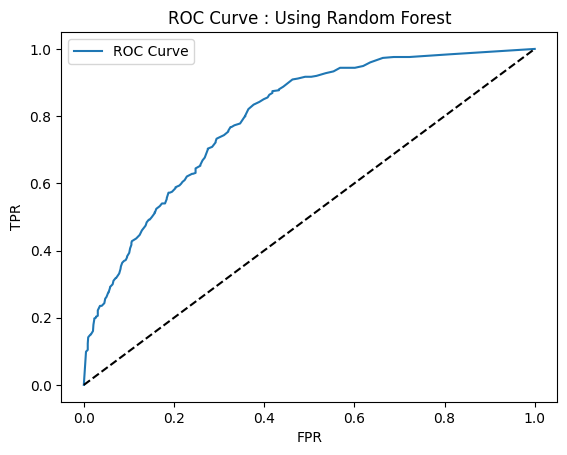

In [45]:
# ROC Curve
y_pred_proba_rfc = rfc.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_rfc)
plt.plot(fpr, tpr, label="ROC Curve")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve : Using Random Forest")
plt.legend()
plt.show()

# **XGBoost Classifier**

Accuracy Score : 0.7306325515280739

 The Classification Report : 

               precision    recall  f1-score   support

           0       0.86      0.76      0.80      1033
           1       0.50      0.66      0.57       374

    accuracy                           0.73      1407
   macro avg       0.68      0.71      0.69      1407
weighted avg       0.76      0.73      0.74      1407



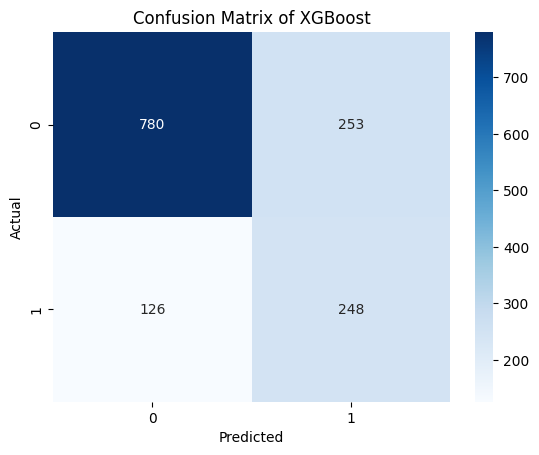

In [46]:
# Initializing the model
xgb_cls = XGBClassifier(eval_metric='mlogloss')

# Train the model using fit
xgb_cls.fit(X_train_smote, y_train_smote)

# Testing of the model/prediction
y_pred_xgb = xgb_cls.predict(X_test_scaled)

# To evaluate how model is performing
print(f'Accuracy Score : {accuracy_score(y_test,y_pred_xgb)}')
print("\n",f'The Classification Report : ')
print("\n", classification_report(y_test,y_pred_xgb))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix of XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

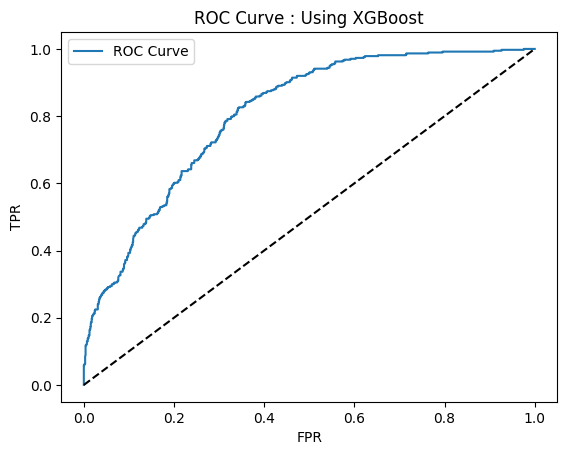

In [47]:
# ROC Curve
y_pred_proba_xgb = xgb_cls.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_xgb)
plt.plot(fpr, tpr, label="ROC Curve")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve : Using XGBoost")
plt.legend()
plt.show()

# **Feed Forward Neural Network**

In [48]:
def create_model(hp=None):
    model = models.Sequential()

    if hp:
        # First hidden layer
        model.add(layers.Dense(
            units=hp.Choice('label_1', values=[32, 64, 128]),
            activation='relu',
            input_shape=(X_train_smote.shape[1],)
        ))

        # Optional second hidden layer
        if hp.Boolean('second_layer'):
            model.add(layers.Dense(
                units=hp.Choice('label_2', values=[16, 32]),
                activation='relu'
            ))

        # Output layer
        model.add(layers.Dense(1, activation='sigmoid'))

        # Compile model
        model.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
    else:
        # Default model without hyperparameter tuning
        model = models.Sequential([
            layers.Dense(64, activation='relu', input_shape=(X_train_smote.shape[1],)),
            layers.Dense(32, activation='relu'),
            layers.Dense(16, activation='relu'),
            layers.Dense(8, activation='relu'),
            layers.Dense(1, activation='sigmoid')
        ])

        model.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

    return model

In [49]:
# Building the Neural Network :

# without passing hp :
first_model = create_model()

# run nn and give certain number of epoch running
history = first_model.fit(
    X_train_smote,
    y_train_smote,
    epochs= 150,
    batch_size=32,
    validation_split=0.20,
    verbose=1
)

Epoch 1/150


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


207/207 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.6055 - loss: 0.6603 - val_accuracy: 0.5757 - val_loss: 0.7555
Epoch 2/150
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7537 - loss: 0.4979 - val_accuracy: 0.7197 - val_loss: 0.5900
Epoch 3/150
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7607 - loss: 0.4824 - val_accuracy: 0.6199 - val_loss: 0.7152
Epoch 4/150
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7714 - loss: 0.4569 - val_accuracy: 0.5648 - val_loss: 0.7675
Epoch 5/150
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7653 - loss: 0.4674 - val_accuracy: 0.6568 - val_loss: 0.6950
Epoch 6/150
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7712 - loss: 0.4582 - val_accuracy: 0.7282 - val_loss: 0.5701
Epoch 7/150
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7673 - loss: 0.4675 - val_accuracy: 0.6628 - val_loss: 0.6605
Epoch 8/150
207/207 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7708 - loss: 0.4662 - val_accuracy: 0.69

In [50]:
print(first_model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,605 (37.52 KB)

 Trainable params: 3,201 (12.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,404 (25.02 KB)

None


# **Predict & Evaluate Using Confusion Matrix**

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


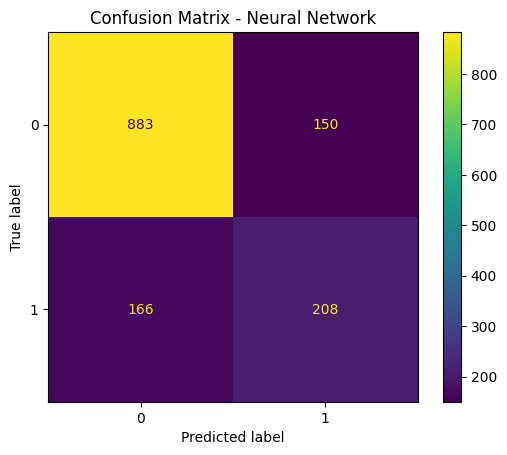

In [51]:
# Predict classes on test set
y_pred = (first_model.predict(X_test_scaled) > 0.5).astype("int32")

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix - Neural Network")
plt.show()

In [52]:
loss, accuracy = first_model.evaluate(X_test_scaled, y_test)
print(f"Test Loss : {loss}")
print(f"Test Accuracy : {accuracy}")

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7697 - loss: 0.4692
Test Loss : 0.47806790471076965
Test Accuracy : 0.7754086852073669


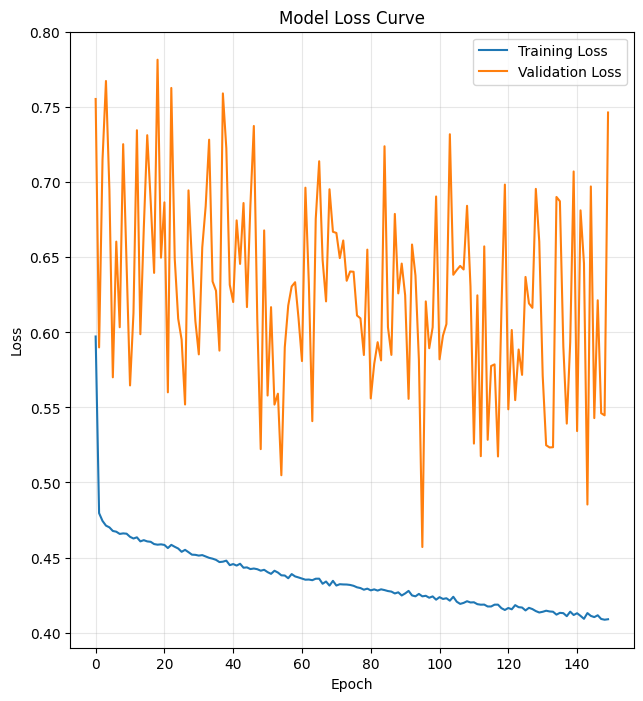

In [53]:
# Plot visual data of loss
plt.figure(figsize=(16,8)) #sizing the canvas
plt.subplot(1,2,1) # (row,col,which position plot will come in)to show plot side by side
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel("Loss")
plt.title("Model Loss Curve")
plt.legend()
plt.grid(alpha=0.3)

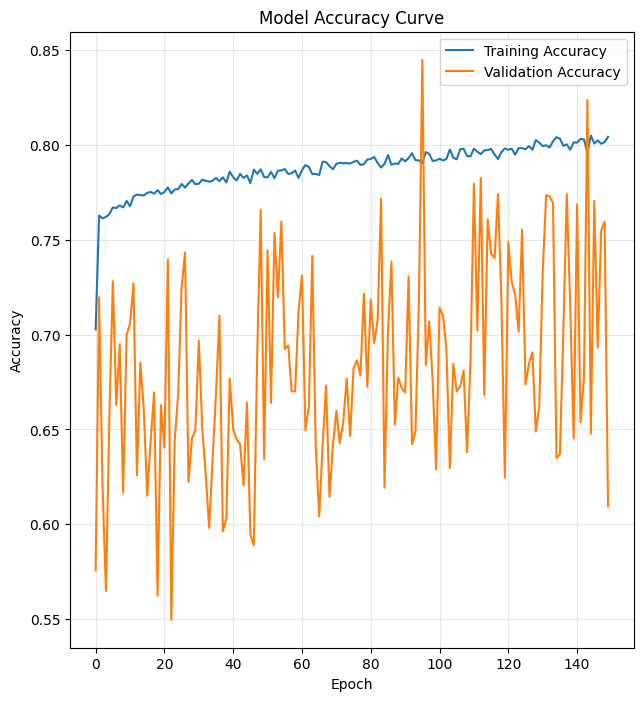

In [54]:
# To Plot the Accuracy :
plt.figure(figsize=(16,8)) #sizing the canvas
plt.subplot(1,2,2) # plot will be on 2nd position
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel("Accuracy")
plt.title("Model Accuracy Curve")
plt.legend()
plt.grid(alpha=0.3)

# **Saving all the Trained Model**

 Saving Scaler and RFE

In [55]:
joblib.dump(scaler, "scaler.pkl")
joblib.dump(rfe, "rfe_selector.pkl")

['rfe_selector.pkl']

# Classifier Models:

In [56]:
# Logistics Regression
dump(Lrs , 'logistics_regression_model.pkl')

# Decision Tree
dump(dtc , 'decision_tree_model.pkl')

# Random Forest
dump(rfc, 'random_forest_model.pkl')

['random_forest_model.pkl']

# Feed Forward Neural Network

In [57]:
first_model.save('ffnn_model.h5')

# **Customer Segmentation**

In [58]:
X_fetures_seg = customer[[
    'tenure' ,
    'MonthlyCharges' ,
    'TotalCharges',
    'SeniorCitizen',
    'Contract',
    'PaymentMethod'
 ]]

In [59]:
# Applying Standard Scaler :
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_fetures_seg)

# **K-Means**

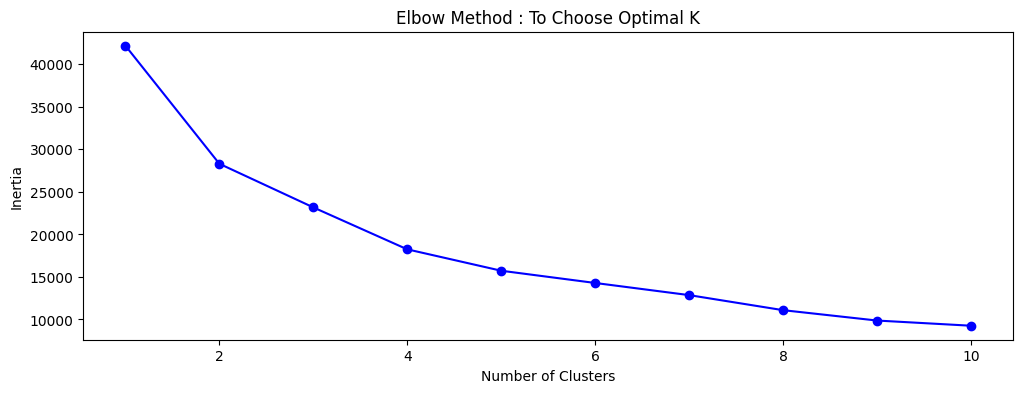

In [60]:
# Find the Optimal number of cluster using Elbow Method
ssd = []
cluster = range(1,11)

for i in cluster :
    model_clus =  KMeans(n_clusters = i , max_iter = 150 , random_state = 42) # creating kmeans model forrach k values
    model_clus.fit(X_scaled)
    ssd.append(model_clus.inertia_)

# Plot
plt.figure(figsize=(12,4))
plt.plot(cluster, ssd , 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method : To Choose Optimal K')
plt.show()

In [61]:
# Silhoutte score

clusters = range(2, 11)
for k in clusters :
    model_clus =  KMeans(n_clusters = k, max_iter = 150 , random_state = 42)
    model_clus.fit(X_scaled)
    cluster_labels = model_clus.labels_ # making cluster labels
    s_score = silhouette_score(X_scaled,cluster_labels)
    print(k, s_score)

2 0.31764786810279094
3 0.2878005923072999
4 0.33945977400803384
5 0.2934465181252138
6 0.2778322540877485
7 0.28856226856441514
8 0.3230152130153048
9 0.32228705293437204
10 0.32735046444058674


In [62]:
# K-Means Clustering
kmeans = KMeans(n_clusters = 4,
                random_state = 42)

kmeans.fit(X_scaled)

cluster_labels = kmeans.labels_
customer['Cluster'] = cluster_labels

### Saving the Cluster Labels Dataset

In [63]:
# Save Trained Model
dump(kmeans , "customer_Segmenatation_model.pkl")

dump(scaler , "customer_segmentation_scaler.pkl")

['customer_segmentation_scaler.pkl']

# **DBSCAN**

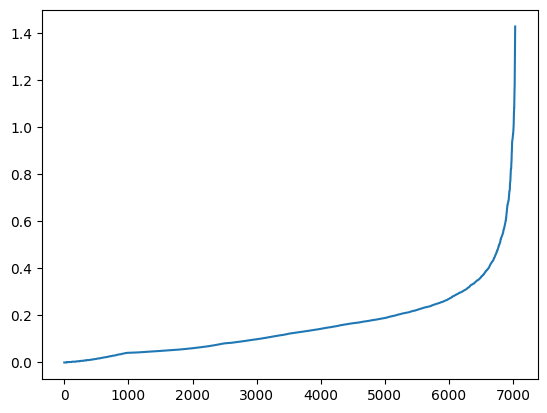

In [64]:
# To choose eps Using K-distance graph:
neighbors = NearestNeighbors(n_neighbors = 5)
neighbors = neighbors.fit(X_scaled)
distances , indices = neighbors.kneighbors(X_scaled)

distances = np.sort(distances[:, 4])
plt.plot(distances)
plt.show()

In [65]:
dbscan = DBSCAN(eps = 0.9 , min_samples = 5 )

dbscan.fit(X_scaled)

dbscan_labels = dbscan.labels_
customer['DBSCAN_Cluster'] = dbscan_labels

In [66]:
# Saving the Model
dump(dbscan , "customer_seg_DBSCAN.pkl")

['customer_seg_DBSCAN.pkl']

In [67]:
# Comparing cluster count:
print(customer['DBSCAN_Cluster'].value_counts())

DBSCAN_Cluster
 0     1337
 2      821
 5      517
 9      513
 8      506
 7      477
 4      433
 16     367
 6      350
 3      326
 1      322
 15     284
 19     150
 12     111
 11     110
 20      70
 18      65
 14      62
 10      51
 17      47
 13      42
-1       29
 22      14
 23      12
 21       9
 24       7
Name: count, dtype: int64


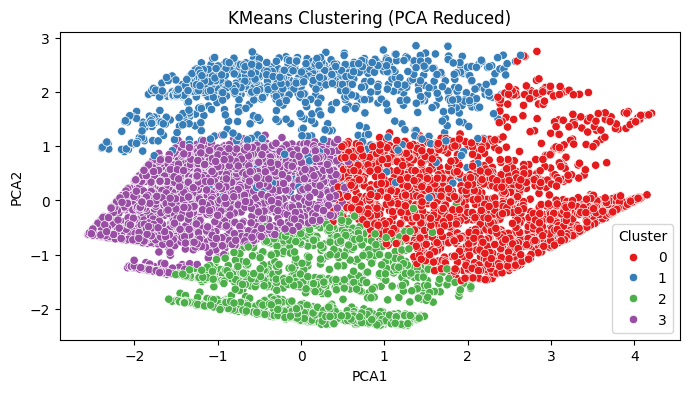

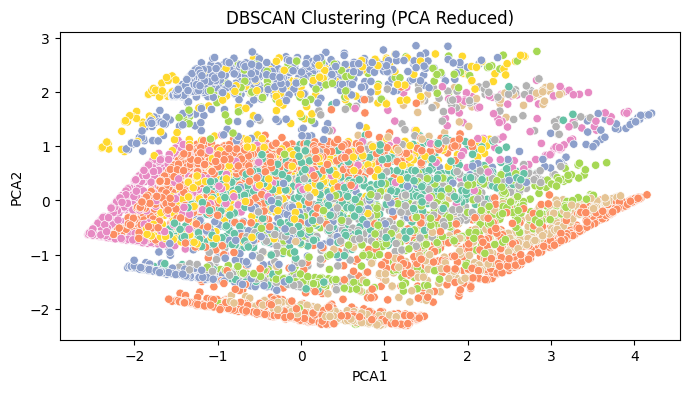

In [68]:
# PCA for 2D Visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

customer['PCA1'] = X_pca[:, 0]
customer['PCA2'] = X_pca[:, 1]

# Plot KMeans
plt.figure(figsize=(8,4))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=customer, palette='Set1')
plt.title("KMeans Clustering (PCA Reduced)")
plt.show()

# Plot DBSCAN
plt.figure(figsize=(8,4))
sns.scatterplot(x='PCA1', y='PCA2', hue='DBSCAN_Cluster', data=customer, palette='Set2')
plt.title("DBSCAN Clustering (PCA Reduced)")
plt.legend().set_visible(False)
plt.show()

# **Customer Segmentation Insights**

- **KMeans** found 4 clear segments based on charges, contract type, and tenure.
- **DBSCAN** failed to form meaningful clusters — too many small groups.
- It matters: because it helps target at-risk customers with offers and improve retention.


# **Tracking through ML Flow**

In [69]:
import shutil
shutil.rmtree("mlruns")

FileNotFoundError: [Errno 2] No such file or directory: 'mlruns'

In [70]:
import os
from pyngrok import ngrok

# Set MLflow to log to local file system
os.environ["MLFLOW_TRACKING_URI"] = "file:///C:/Users/aparn/Downloads/mlrun"

# Start the MLflow tracking UI on port 5000
#get_ipython().system_raw("mlflow ui --port 5000 &")


In [71]:
!ngrok config add-authtoken "3056lIUVu1PaNKDAbZeluKmDvbc_2SGC3Vh1ckMLybi5w83gK"

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [72]:
# Start the MLflow tracking UI on port 5000
get_ipython().system_raw("mlflow ui --backend-store-uri file:///C:/Users/aparn/Downloads/mlrun --port 5000 &")

In [73]:
# Get ngrok URL
public_url = ngrok.connect(5000)
print(f"MLflow UI: {public_url}")

MLflow UI: NgrokTunnel: "https://b2c5a990c9ff.ngrok-free.app" -> "http://localhost:5000"


# **Logging All ML Models in ML-Flow**

In [74]:
# Define models and names
models = {
    "Logistic Regression": Lrs,
    "Decision Tree": dtc,
    "Random Forest": rfc,
    "XGBoost": xgb_cls
}
mlflow.set_tracking_uri("file:///C:/Users/aparn/Downloads/mlrun")
mlflow.set_experiment("Customer Churn Models")

for name, model in models.items():
    print(f"Logging {name} to MLflow...")

    # Predict
    y_pred = model.predict(X_test_scaled)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    cm = confusion_matrix(y_test, y_pred)

    with mlflow.start_run(run_name=name):

        # Log model
        mlflow.sklearn.log_model(model, artifact_path="model")

        # Log metrics
        mlflow.log_metric("accuracy", acc)
        mlflow.log_metric("precision", report['weighted avg']['precision'])
        mlflow.log_metric("recall", report['weighted avg']['recall'])
        mlflow.log_metric("f1_score", report['weighted avg']['f1-score'])

        # Confusion Matrix Plot
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f"Confusion Matrix - {name}")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        with tempfile.NamedTemporaryFile(suffix=".png", delete=False) as tmp:
            plt.savefig(tmp.name)
            mlflow.log_artifact(tmp.name, artifact_path="plots")
            plt.close()

        # ROC Curve (only for models with predict_proba)
        if hasattr(model, "predict_proba"):
            y_prob = model.predict_proba(X_test_scaled)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, y_prob)
            plt.figure(figsize=(6, 4))
            plt.plot(fpr, tpr, label="ROC Curve")
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title(f"ROC Curve - {name}")
            plt.legend()
            with tempfile.NamedTemporaryFile(suffix=".png", delete=False) as tmp:
                plt.savefig(tmp.name)
                mlflow.log_artifact(tmp.name, artifact_path="plots")
                plt.close()

    print(f"Logged {name} successfully.\n")

2025/07/19 12:06:53 INFO mlflow.tracking.fluent: Experiment with name 'Customer Churn Models' does not exist. Creating a new experiment.
2025/07/19 12:06:53 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Logging Logistic Regression to MLflow...


2025/07/19 12:07:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/07/19 12:07:00 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Logged Logistic Regression successfully.

Logging Decision Tree to MLflow...


2025/07/19 12:07:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/07/19 12:07:03 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Logged Decision Tree successfully.

Logging Random Forest to MLflow...


2025/07/19 12:07:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/07/19 12:07:07 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Logged Random Forest successfully.

Logging XGBoost to MLflow...


2025/07/19 12:07:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logged XGBoost successfully.



# **Logging FFNN**

In [75]:
# Start MLflow logging
with mlflow.start_run(run_name="FFNN Logging"):

    # Evaluate metrics
    loss, accuracy = first_model.evaluate(X_test_scaled, y_test)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Log metrics
    mlflow.log_metric("test_loss", loss)
    mlflow.log_metric("test_accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)

    # Log model
    mlflow.tensorflow.log_model(first_model, artifact_path="FFNN_model")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix - Neural Network")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    with tempfile.NamedTemporaryFile(suffix=".png", delete=False) as tmp:
        plt.savefig(tmp.name)
        plt.close()
        mlflow.log_artifact(tmp.name, artifact_path="plots")
    #Accuracy :
    plt.figure(figsize=(16,8)) #sizing the canvas
    plt.subplot(1,2,2) # plot will be on 2nd position
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel("Accuracy")
    plt.title("Model Accuracy Curve")
    plt.legend()
    plt.grid(alpha=0.3)
    with tempfile.NamedTemporaryFile(suffix=".png", delete=False) as tmp:
        plt.savefig(tmp.name)
        plt.close()
        mlflow.log_artifact(tmp.name, artifact_path="plots")



    # ROC Curve
    y_pred_prob = first_model.predict(X_test_scaled).ravel()
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    plt.figure()
    plt.plot(fpr, tpr, label="ROC Curve")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title("ROC Curve: FFNN")
    plt.legend()
    with tempfile.NamedTemporaryFile(suffix=".png", delete=False) as tmp:
      plt.savefig(tmp.name)
      plt.close()
      mlflow.log_artifact(tmp.name, artifact_path="plots")

    print("✅ FFNN logs saved to MLflow.")


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7697 - loss: 0.4692


2025/07/19 12:07:51 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/19 12:07:51 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/07/19 12:08:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
✅ FFNN logs saved to MLflow.


# **Logging K-Means and DBSCAN**

In [76]:
with mlflow.start_run(run_name="KMeans Clustering"):

    # Log Parameters
    mlflow.log_param("KMeans_n_clusters", 4)

    # Silhouette Score
    kmeans_score = silhouette_score(X_scaled, customer['Cluster'])
    mlflow.log_metric("KMeans_silhouette_score", kmeans_score)

    # Elbow Plot
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, 11), ssd, 'bo-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Method')
    with tempfile.NamedTemporaryFile(suffix=".png", delete=False) as tmp:
        plt.savefig(tmp.name)
        plt.close()
        mlflow.log_artifact(tmp.name, artifact_path="plots")

    # Silhouette Scores for K = 2 to 10
    sil_scores = []
    for k in range(2, 11):
        km = KMeans(n_clusters=k, random_state=42)
        km.fit(X_scaled)
        score = silhouette_score(X_scaled, km.labels_)
        sil_scores.append(score)

    plt.figure(figsize=(8, 4))
    plt.plot(range(2, 11), sil_scores, 'go-')
    plt.xlabel("Clusters")
    plt.ylabel("Silhouette Score")
    plt.title("Silhouette Scores by Cluster Count")
    with tempfile.NamedTemporaryFile(suffix=".png", delete=False) as tmp:
        plt.savefig(tmp.name)
        plt.close()
        mlflow.log_artifact(tmp.name, artifact_path="plots")

    # PCA Scatter Plot for KMeans
    plt.figure(figsize=(8, 4))
    sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=customer, palette='Set1')
    plt.title("KMeans Clustering (PCA Reduced)")
    with tempfile.NamedTemporaryFile(suffix=".png", delete=False) as tmp:
        plt.savefig(tmp.name)
        plt.close()
        mlflow.log_artifact(tmp.name, artifact_path="plots")

    print("✅ KMeans clustering logged to MLflow.")

✅ KMeans clustering logged to MLflow.


In [77]:
with mlflow.start_run(run_name="DBSCAN Clustering"):

    # Log Parameters
    mlflow.log_param("DBSCAN_eps", 0.9)
    mlflow.log_param("DBSCAN_min_samples", 5)

    # Silhouette Score
    dbscan_labels = customer['DBSCAN_Cluster']
    if len(set(dbscan_labels)) > 1 and -1 in dbscan_labels:
        valid_labels = dbscan_labels[dbscan_labels != -1]
        valid_X = X_scaled[dbscan_labels != -1]
        score = silhouette_score(valid_X, valid_labels)
        mlflow.log_metric("DBSCAN_silhouette_score (no noise)", score)

    # PCA Scatter Plot for DBSCAN
    plt.figure(figsize=(8, 4))
    sns.scatterplot(x='PCA1', y='PCA2', hue='DBSCAN_Cluster', data=customer, palette='Set2')
    plt.title("DBSCAN Clustering (PCA Reduced)")
    plt.legend().set_visible(False)
    with tempfile.NamedTemporaryFile(suffix=".png", delete=False) as tmp:
        plt.savefig(tmp.name)
        plt.close()
        mlflow.log_artifact(tmp.name, artifact_path="plots")

    print("✅ DBSCAN clustering logged to MLflow.")


✅ DBSCAN clustering logged to MLflow.


# **Hyper-Parameter Tuning**

Logistics Regression

In [78]:
param_grid = [
    {  # l2 penalty with lbfgs or liblinear
        'penalty': ['l2'],
        'solver': ['lbfgs', 'liblinear'],
        'C': np.logspace(-3, 2, 10),
    },
    {  # l1 penalty with liblinear
        'penalty': ['l1'],
        'solver': ['liblinear'],
        'C': np.logspace(-3, 2, 10),
    },
    {  # elasticnet with saga only
        'penalty': ['elasticnet'],
        'solver': ['saga'],
        'l1_ratio': [0.3, 0.5, 0.7],  # required for elasticnet
        'C': np.logspace(-3, 2, 10),
    }
]

lr = LogisticRegression(max_iter=1000)

random_search_lor = RandomizedSearchCV(
    estimator=lr,
    param_distributions=param_grid,
    n_iter=50,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)

random_search_lor.fit(X_train_smote, y_train_smote)

RandomizedSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000), n_iter=50,
                   n_jobs=-1,
                   param_distributions=[{'C': array([1.00000000e-03, 3.59381366e-03, 1.29154967e-02, 4.64158883e-02,
       1.66810054e-01, 5.99484250e-01, 2.15443469e+00, 7.74263683e+00,
       2.78255940e+01, 1.00000000e+02]),
                                         'penalty': ['l2'],
                                         'solver': ['lbfgs', 'liblinear']},
                                        {'C': array([1.00000000e-03, 3...
       1.66810054e-01, 5.99484250e-01, 2.15443469e+00, 7.74263683e+00,
       2.78255940e+01, 1.00000000e+02]),
                                         'penalty': ['l1'],
                                         'solver': ['liblinear']},
                                        {'C': array([1.00000000e-03, 3.59381366e-03, 1.29154967e-02, 4.64158883e-02,
       1.66810054e-01, 5.99484250e-01, 2.15443469e+00, 7.74263683e+00,
       2.78255940e+01, 1.00000000e+02]),
                                         'l1_ratio': [0.3, 0.5, 0.7],
                                         'penalty': ['elasticnet'],
                                         'solver': ['saga']}],
                   random_state=42, scoring='accuracy')

In [79]:
print("Best Accuracy From Logistics Regression after using Random Serach : ",random_search_lor.best_score_)
print("Best Parameters From Logistics Regression after using Random Serach : ",random_search_lor.best_params_)

Best Accuracy From Logistics Regression after using Random Serach :  0.7564164648910412
Best Parameters From Logistics Regression after using Random Serach :  {'solver': 'lbfgs', 'penalty': 'l2', 'C': np.float64(27.825594022071257)}


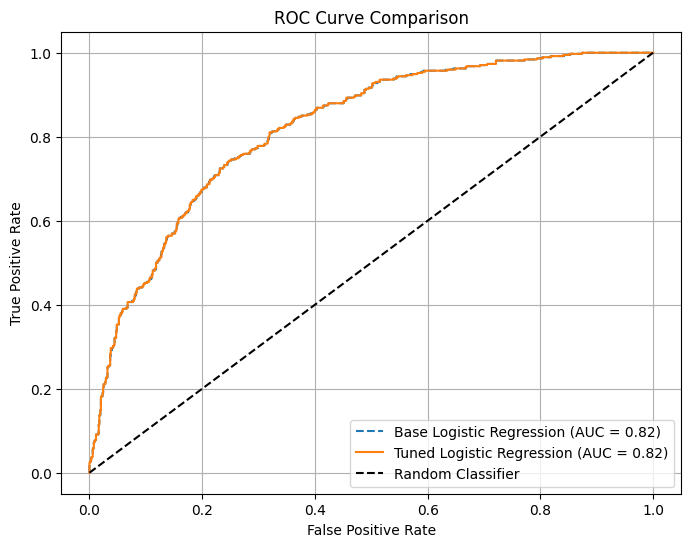

In [80]:
# Default or baseline model prediction
y_pred_proba_base = Lrs.predict_proba(X_test_scaled)[:, 1]
fpr_base, tpr_base, _ = roc_curve(y_test, y_pred_proba_base)
auc_base = auc(fpr_base, tpr_base)

# Best model from RandomizedSearchCV
best_model = random_search_lor.best_estimator_
y_pred_proba_best = best_model.predict_proba(X_test_scaled)[:, 1]
fpr_best, tpr_best, _ = roc_curve(y_test, y_pred_proba_best)
auc_best = auc(fpr_best, tpr_best)

# Plot both ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_base, tpr_base, label=f"Base Logistic Regression (AUC = {auc_base:.2f})", linestyle='--')
plt.plot(fpr_best, tpr_best, label=f"Tuned Logistic Regression (AUC = {auc_best:.2f})", linestyle='-')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

# Labels and styling
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [81]:
# Predictions
y_pred_base = Lrs.predict(X_test_scaled)
y_pred_tuned = best_model.predict(X_test_scaled)

# Reports
print("Base Model Report:\n", classification_report(y_test, y_pred_base))
print("Tuned Model Report:\n", classification_report(y_test, y_pred_tuned))

Base Model Report:
               precision    recall  f1-score   support

           0       0.90      0.69      0.78      1033
           1       0.48      0.78      0.59       374

    accuracy                           0.71      1407
   macro avg       0.69      0.74      0.69      1407
weighted avg       0.79      0.71      0.73      1407

Tuned Model Report:
               precision    recall  f1-score   support

           0       0.90      0.69      0.78      1033
           1       0.48      0.78      0.59       374

    accuracy                           0.71      1407
   macro avg       0.69      0.74      0.69      1407
weighted avg       0.79      0.71      0.73      1407



**Logistic Regression Tunned Model into ML Flow**

In [82]:
with mlflow.start_run(run_name = "Logistics Regression tuned Random search"):
  best_model = random_search_lor.best_estimator_
  mlflow.sklearn.log_model(best_model , "log_reg_tuned_random_models")
  mlflow.log_params(random_search_lor.best_params_)
  mlflow.log_metric("best_accuracy" , random_search_lor.best_score_)
  print("Random Search Tuned Logistics Regression Model logged with ML-Flow")

2025/07/19 12:09:37 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/19 12:09:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Random Search Tuned Logistics Regression Model logged with ML-Flow


# **Random Forest**

In [83]:

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'max_features': ['sqrt', 'log2', None],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 4]
}

In [84]:
rf = RandomForestClassifier(random_state = 42)

random_search_rf = RandomizedSearchCV(
    estimator = rf,
    param_distributions = param_grid,
    n_iter = 20,
    cv = 5,
    verbose = 2,
    n_jobs = -1,
    random_state = 42
)

random_search_rf.fit(X_train_smote, y_train_smote)
print("Best Parameters:", random_search_rf.best_params_)
print("Best Accuracy:", random_search_rf.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'n_estimators': 300, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20}
Best Accuracy: 0.8144067796610169


In [85]:
joblib.dump(random_search_rf , "random_forest_tunned.pkl")

['random_forest_tunned.pkl']

In [86]:
joblib.dump(random_search_rf , "random_forest_tuned_compressed.z", compress=3)

['random_forest_tuned_compressed.z']

**Random Forest Tunned Model into ML Flow**

In [87]:
with mlflow.start_run(run_name="Random Forest tuned Random search"):
    best_model = random_search_rf.best_estimator_
    mlflow.sklearn.log_model(best_model, "random_forest_tuned_random_models")
    mlflow.log_params(random_search_rf.best_params_)
    mlflow.log_metric("best_accuracy", random_search_rf.best_score_)
    print("Random Search Tuned Random Forest Model logged with ML-Flow")

2025/07/19 12:14:25 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/19 12:14:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Random Search Tuned Random Forest Model logged with ML-Flow


In [90]:
from scipy.stats import randint, uniform

# Define base model
xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)

# Define hyperparameter distributions
param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4)
}

# Setup RandomizedSearchCV
random_search_xgb = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=25,
    scoring='accuracy',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit on training data
random_search_xgb.fit(X_train_smote, y_train_smote)

# Best parameters and model
print("✅ Best Parameters:", random_search_xgb.best_params_)
best_xgb = random_search_xgb.best_estimator_

# Evaluate
y_pred_xgb = best_xgb.predict(X_test_scaled)
print("\n Classification Report:\n", classification_report(y_test, y_pred_xgb))

Fitting 5 folds for each of 25 candidates, totalling 125 fits
✅ Best Parameters: {'colsample_bytree': np.float64(0.9757995766256756), 'learning_rate': np.float64(0.27844820512829466), 'max_depth': 8, 'n_estimators': 144, 'subsample': np.float64(0.9687496940092467)}

 Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.77      0.81      1033
           1       0.49      0.61      0.55       374

    accuracy                           0.73      1407
   macro avg       0.67      0.69      0.68      1407
weighted avg       0.75      0.73      0.74      1407



In [95]:
print("Best Accuracy From XGboost after using Random Search : ",random_search_xgb.best_score_)
print("Best Parameters From XGBoost Regression after using Random Search : ",random_search_xgb.best_params_)

Best Accuracy From XGboost after using Random Search :  0.8112590799031476
Best Parameters From XGBoost Regression after using Random Search :  {'colsample_bytree': np.float64(0.9757995766256756), 'learning_rate': np.float64(0.27844820512829466), 'max_depth': 8, 'n_estimators': 144, 'subsample': np.float64(0.9687496940092467)}


In [96]:
print("Best Accuracy:", random_search_xgb.best_score_)

Best Accuracy: 0.8112590799031476


In [92]:
joblib.dump(random_search_rf , "XGBoost_tunned.pkl")

['XGBoost_tunned.pkl']

In [97]:
joblib.dump(random_search_rf , "XGBoost_tuned_compressed.z", compress=3)

['XGBoost_tuned_compressed.z']

In [98]:
with mlflow.start_run(run_name="XGBoost tuned Random search"):
    best_model = random_search_xgb.best_estimator_
    mlflow.sklearn.log_model(best_model, "xgboost_tuned_random_models")
    mlflow.log_params(random_search_xgb.best_params_)
    mlflow.log_metric("best_accuracy", random_search_xgb.best_score_)
    print("Random Search Tuned XGBoost Model logged with ML-Flow")

2025/07/19 12:24:05 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/19 12:24:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Random Search Tuned XGBoost Model logged with ML-Flow


**Tuning FFNN**

In [100]:
from tensorflow.keras import models
from tensorflow.keras import layers

tuner = RandomSearch(
    create_model,
    objective = 'val_accuracy',
    max_trials = 10,
    executions_per_trial = 1,
    directory = 'ffnn-tuning',
    project_name = 'Customer Churn'
)


tuner.search(X_train_smote ,
             y_train_smote,
             epochs = 20,
             validation_split = 0.2,
             batch_size = 32)

# For getting the best model:
best = tuner.get_best_hyperparameters(num_trials = 1)[0]
best_model_fnn = tuner.hypermodel.build(best)

# Re-training
best_model_fnn.fit(X_train_smote ,
                   y_train_smote ,
                   epochs = 20,
                   validation_split = 0.2)

Trial 10 Complete [00h 00m 16s]
val_accuracy: 0.6870459914207458

Best val_accuracy So Far: 0.7378934621810913
Total elapsed time: 00h 02m 48s
Epoch 1/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7361 - loss: 0.5293 - val_accuracy: 0.6574 - val_loss: 0.6867
Epoch 2/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7639 - loss: 0.4710 - val_accuracy: 0.6810 - val_loss: 0.6533
Epoch 3/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7604 - loss: 0.4739 - val_accuracy: 0.6689 - val_loss: 0.6683
Epoch 4/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7684 - loss: 0.4665 - val_accuracy: 0.7046 - val_loss: 0.6390
Epoch 5/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7561 - loss: 0.4761 - val_accuracy: 0.6610 - val_loss: 0.6640
Epoch 6/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7638 - loss: 0.4699 - val_accuracy: 0.6822 - val_loss: 0.6738
Epoch 7/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7663 - loss: 0.4724 - v

In [101]:
best_model_fnn.save("FFNN_Tuned_Model.h5")

In [102]:
mlflow.tensorflow.autolog()

with mlflow.start_run(run_name = "FFNN_Tuned"):
  mlflow.log_param("unit_layer1" , best.get('label_1'))
  mlflow.log_param("unit_layer2" , best.get('label_2'))
  mlflow.log_param("second_layer" , best.get('second_layer'))


# Log metrics:
  val_accuracy = best_model_fnn.evaluate(X_train_smote,
                                   y_train_smote,
                                   verbose = 0)[1]

  mlflow.keras.log_model(best_model_fnn, "FFNN_Tuned_Model")

  print("Best Model FFNN Tunned logged with ML Flow")

2025/07/19 12:30:06 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/19 12:30:06 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/07/19 12:30:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Best Model FFNN Tunned logged with ML Flow


In [103]:
joblib.dump(rfe, "rfe_selector_compressed.z", compress=3)

['rfe_selector_compressed.z']

# **Gradio Integration**

In [104]:
scaler.feature_names_in_

array(['tenure', 'MonthlyCharges', 'TotalCharges', 'SeniorCitizen',
       'Contract', 'PaymentMethod'], dtype=object)

In [105]:
import gradio as gr

In [107]:
def predict_churn(
    senior_citizen, tenure, device_protection, tech_support,
    contract, total_charges, payment_method, monthly_charges,
    streaming_movies, partner, internet_service
):
    try:
        # Step 1: Manual encodings to match training
        label_maps = {
            'DeviceProtection': {'No': 0, 'Yes': 1},
            'TechSupport': {'No': 0, 'Yes': 1},
            'Contract': {'Month-to-month': 0, 'One year': 1, 'Two year': 2},
            'PaymentMethod': {
                'Electronic check': 0, 'Mailed check': 1,
                'Bank transfer (automatic)': 2, 'Credit card (automatic)': 3
            },
            'StreamingMovies': {'No': 0, 'Yes': 1},
            'Partner': {'No': 0, 'Yes': 1},
            'InternetService': {'DSL': 0, 'Fiber optic': 1, 'No': 2}
        }

        row = {
            'SeniorCitizen': int(senior_citizen),
            'tenure': float(tenure),
            'DeviceProtection': label_maps['DeviceProtection'][device_protection],
            'TechSupport': label_maps['TechSupport'][tech_support],
            'Contract': label_maps['Contract'][contract],
            'TotalCharges': float(total_charges),
            'PaymentMethod': label_maps['PaymentMethod'][payment_method],
            'MonthlyCharges': float(monthly_charges),
            'StreamingMovies': label_maps['StreamingMovies'][streaming_movies],
            'Partner': label_maps['Partner'][partner],
            'InternetService': label_maps['InternetService'][internet_service]
        }

        # Step 2: Build full input in correct order
        df = pd.DataFrame([row])[[
            'SeniorCitizen','tenure','DeviceProtection','TechSupport','Contract','TotalCharges',
            'PaymentMethod','MonthlyCharges','StreamingMovies','Partner','InternetService'
        ]]

        # Step 3: RFE transform
        selected = rfe.transform(df)

        # Step 4: Scale the selected features
        scaled = scaler.transform(selected)

        # Step 5: Predict
        prediction = random_search_xgb.predict(scaled)[0]

        return "❌ Churn" if prediction == 1 else "✅ Not Churn"

    except Exception as e:
        return f"⚠️ Error: {str(e)}"

In [108]:
demo = gr.Interface(
    fn=predict_churn,
    inputs=[
        gr.Checkbox(label="Senior Citizen"),
        gr.Number(label="Tenure"),
        gr.Dropdown(['No', 'Yes'], label="Device Protection"),
        gr.Dropdown(['No', 'Yes'], label="Tech Support"),
        gr.Dropdown(['Month-to-month', 'One year', 'Two year'], label="Contract"),
        gr.Number(label="Total Charges"),
        gr.Dropdown(['Electronic check', 'Mailed check', 'Bank transfer (automatic)', 'Credit card (automatic)'], label="Payment Method"),
        gr.Number(label="Monthly Charges"),
        gr.Dropdown(['No', 'Yes'], label="Streaming Movies"),
        gr.Dropdown(['No', 'Yes'], label="Partner"),
        gr.Dropdown(['DSL', 'Fiber optic', 'No'], label="Internet Service")
    ],
    outputs="text",
    title="📉 Customer Churn Predictor",
    description="11-input model RFE + scaler + Trained and Tuned XGBoost"
)

demo.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://74210d45131a11131e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# **Logged Gradio App**

In [109]:
gradio_code = '''
import gradio as gr
import pickle
import numpy as np
import pandas as pd

# Load saved components
with open("random_forest_tunned.pkl", "rb") as f:
    model = pickle.load(f)
with open("scaler.pkl", "rb") as f:
    scaler = pickle.load(f)
with open("rfe_selector.pkl", "rb") as f:
    rfe = pickle.load(f)

def predict_churn(
    senior_citizen, tenure, device_protection, tech_support,
    contract, total_charges, payment_method, monthly_charges,
    streaming_movies, partner, internet_service
):
    try:
        # Step 1: Manual encodings to match training
        label_maps = {
            'DeviceProtection': {'No': 0, 'Yes': 1},
            'TechSupport': {'No': 0, 'Yes': 1},
            'Contract': {'Month-to-month': 0, 'One year': 1, 'Two year': 2},
            'PaymentMethod': {
                'Electronic check': 0, 'Mailed check': 1,
                'Bank transfer (automatic)': 2, 'Credit card (automatic)': 3
            },
            'StreamingMovies': {'No': 0, 'Yes': 1},
            'Partner': {'No': 0, 'Yes': 1},
            'InternetService': {'DSL': 0, 'Fiber optic': 1, 'No': 2}
        }

        row = {
            'SeniorCitizen': int(senior_citizen),
            'tenure': float(tenure),
            'DeviceProtection': label_maps['DeviceProtection'][device_protection],
            'TechSupport': label_maps['TechSupport'][tech_support],
            'Contract': label_maps['Contract'][contract],
            'TotalCharges': float(total_charges),
            'PaymentMethod': label_maps['PaymentMethod'][payment_method],
            'MonthlyCharges': float(monthly_charges),
            'StreamingMovies': label_maps['StreamingMovies'][streaming_movies],
            'Partner': label_maps['Partner'][partner],
            'InternetService': label_maps['InternetService'][internet_service]
        }

        # Step 2: Build full input in correct order
        df = pd.DataFrame([row])[[
            'SeniorCitizen','tenure','DeviceProtection','TechSupport','Contract','TotalCharges',
            'PaymentMethod','MonthlyCharges','StreamingMovies','Partner','InternetService'
        ]]

        # Step 3: RFE transform
        selected = rfe.transform(df)

        # Step 4: Scale the selected features
        scaled = scaler.transform(selected)

        # Step 5: Predict
        prediction = random_search_xgb.predict(scaled)[0]

        return "❌ Churn" if prediction == 1 else "✅ Not Churn"

    except Exception as e:
        return f"⚠️ Error: {str(e)}"

demo = gr.Interface(
    fn=predict_churn,
    inputs=[
        gr.Checkbox(label="Senior Citizen"),
        gr.Number(label="Tenure"),
        gr.Dropdown(['No', 'Yes'], label="Device Protection"),
        gr.Dropdown(['No', 'Yes'], label="Tech Support"),
        gr.Dropdown(['Month-to-month', 'One year', 'Two year'], label="Contract"),
        gr.Number(label="Total Charges"),
        gr.Dropdown(['Electronic check', 'Mailed check', 'Bank transfer (automatic)', 'Credit card (automatic)'], label="Payment Method"),
        gr.Number(label="Monthly Charges"),
        gr.Dropdown(['No', 'Yes'], label="Streaming Movies"),
        gr.Dropdown(['No', 'Yes'], label="Partner"),
        gr.Dropdown(['DSL', 'Fiber optic', 'No'], label="Internet Service")
    ],
    outputs="text",
    title="📉 Customer Churn Predictor",
    description="11-input model with RFE + scaler + Trained and Tuned XGBoost"
)

demo.launch()
'''

# Save to a .py file
with open("gradio_app.py", "w") as f:
    f.write(gradio_code)

In [112]:
from google.colab import files
uploaded = files.upload()

Saving Screenshot 2025-07-19 180524.png to Screenshot 2025-07-19 180524 (1).png


In [113]:
with mlflow.start_run(run_name="Gradio App"):
    mlflow.log_artifact("gradio_app.py", artifact_path="gradio_ui")
    mlflow.log_artifact("Screenshot 2025-07-19 180524.png", artifact_path="gradio_ui")
    mlflow.set_tag("Gradio_App_URL", "https://74210d45131a11131e.gradio.live/")
    print("✅ Gradio app saved and logged.")

✅ Gradio app saved and logged.
